In [221]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cpu_unpickler import CPU_Unpickler
from data import create_spiral
from torchmetrics import Accuracy
from models import SpiralModelTripleLayer
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, x1_dim, x2_dim, x3_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()

        # encoder
        self.encoder_nn1 = nn.Sequential(
            nn.Linear(x1_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.encoder_nn2 = nn.Sequential(
            nn.Linear(x2_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.encoder_nn3 = nn.Sequential(
            nn.Linear(x3_dim + (hidden_dim), hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.logvar = nn.Linear(hidden_dim, z_dim)

        # decoder
        self.decoder_nn3 = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.decoder_nn2 = nn.Sequential(
            nn.Linear(hidden_dim + z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.decoder_nn1 = nn.Sequential(
            nn.Linear(hidden_dim + z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.reconstruct_w1 = nn.Linear(hidden_dim, x1_dim)
        self.reconstruct_w2 = nn.Linear(hidden_dim, x2_dim)
        self.reconstruct_w3 = nn.Linear(hidden_dim, x3_dim)

    def encode(self, w1, w2, w3):
        h1 = self.encoder_nn1(w1)
        h2 = self.encoder_nn2(torch.cat((w2, h1), dim=1))
        h3 = self.encoder_nn3(torch.cat((w3, h2), dim=1))

        mu = self.mu(h3)
        logvar = self.logvar(h3)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3_decoded = self.decoder_nn3(z)
        w3_hat = self.reconstruct_w3(h3_decoded)

        h2_decoded = self.decoder_nn2(torch.cat((h3_decoded, z), dim=1))
        w2_hat = self.reconstruct_w2(h2_decoded)

        h1_decoded = self.decoder_nn1(torch.cat((h2_decoded, z), dim=1))
        w1_hat = self.reconstruct_w1(h1_decoded)

        return w1_hat, w2_hat, w3_hat

    def forward(self, w1, w2, w3):
        mu, logvar = self.encode(w1, w2, w3)
        z = self.reparameterize(mu, logvar)
        w1_hat, w2_hat, w3_hat = self.decode(z)
        return w1_hat, w2_hat, w3_hat, mu, logvar


def loss_function(w1_hat, w2_hat, w3_hat, w1, w2, w3, mu, logvar):
    recon_loss1 = F.mse_loss(w1_hat, w1, reduction="sum")
    recon_loss2 = F.mse_loss(w2_hat, w2, reduction="sum")
    recon_loss3 = F.mse_loss(w3_hat, w3, reduction="sum")
    recon_loss = recon_loss1 + recon_loss2 + recon_loss3
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss

In [223]:
with open("3_layer_models.pickle", "rb") as f:
    real_models = CPU_Unpickler(f).load()


class WeightsDataset(Dataset):
    def __init__(self, state_dicts):
        self.data = [self.flatten_state_dict(sd) for sd in state_dicts]
        self.data = self.global_normalize(self.data)

    def flatten_state_dict(self, state_dict):
        w1 = state_dict["linear1.weight"].view(-1)
        b1 = state_dict["linear1.bias"].view(-1)
        w2 = state_dict["linear2.weight"].view(-1)
        b2 = state_dict["linear2.bias"].view(-1)
        w3 = state_dict["linear3.weight"].view(-1)
        b3 = state_dict["linear3.bias"].view(-1)
        flattened_w1 = torch.cat([w1, b1])
        flattened_w2 = torch.cat([w2, b2])
        flattened_w3 = torch.cat([w3, b3])
        return flattened_w1, flattened_w2, flattened_w3

    def global_normalize(self, data):
        all_w1 = torch.cat([w1 for w1, _, _ in self.data])
        all_w2 = torch.cat([w2 for _, w2, _ in self.data])
        all_w3 = torch.cat([w3 for _, _, w3 in self.data])
        all = torch.cat([all_w1, all_w2, all_w3])
        mean, std = all.mean(), all.std()
        data = [
            (self.normalize(w1, mean, std), self.normalize(w2, mean, std), self.normalize(w3, mean, std))
            for w1, w2, w3 in self.data
        ]
        return data

    def minmax(self, data, min, max):
        return (2 * (data - min)) / (max - min) - 1

    def normalize(self, data, mean, std):
        return (data - mean) / std

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


train_dataset = WeightsDataset(real_models)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

sample = train_dataset[0]
w1_size, w2_size, w3_size = (
    sample[0].size()[0],
    sample[1].size()[0],
    sample[2].size()[0],
)

In [224]:
z_dim = 128
vae = VAE(x1_dim=w1_size, x2_dim=w2_size, x3_dim=w3_size, hidden_dim=128, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
losses = []
epochs = 100
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for i, batch in enumerate(train_loader):
        w1, w2, w3 = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        w1_hat, w2_hat, w3_hat, mu, logvar = vae(w1, w2, w3)
        loss = loss_function(w1_hat, w2_hat, w3_hat, w1, w2, w3, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    print("Epoch: {}, Loss: {:.4f}".format(epoch, avg_loss))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Epoch: 0, Loss: 172.7277
Epoch: 1, Loss: 171.8091
Epoch: 2, Loss: 171.6333
Epoch: 3, Loss: 171.0925
Epoch: 4, Loss: 169.5069
Epoch: 5, Loss: 167.5377
Epoch: 6, Loss: 165.5473
Epoch: 7, Loss: 164.0314
Epoch: 8, Loss: 163.1131
Epoch: 9, Loss: 162.1356
Epoch: 10, Loss: 161.2795
Epoch: 11, Loss: 160.3483
Epoch: 12, Loss: 159.7196
Epoch: 13, Loss: 159.4811
Epoch: 14, Loss: 158.8130
Epoch: 15, Loss: 158.3971
Epoch: 16, Loss: 157.6287
Epoch: 17, Loss: 157.3611
Epoch: 18, Loss: 157.0817
Epoch: 19, Loss: 156.6527
Epoch: 20, Loss: 156.1216
Epoch: 21, Loss: 155.7973
Epoch: 22, Loss: 155.2290
Epoch: 23, Loss: 154.6027
Epoch: 24, Loss: 154.4305
Epoch: 25, Loss: 154.0536
Epoch: 26, Loss: 153.5085
Epoch: 27, Loss: 153.4251
Epoch: 28, Loss: 153.0084
Epoch: 29, Loss: 152.5122
Epoch: 30, Loss: 151.9417
Epoch: 31, Loss: 151.7124
Epoch: 32, Loss: 151.1335
Epoch: 33, Loss: 150.9454
Epoch: 34, Loss: 150.5613
Epoch: 35, Loss: 150.5353
Epoch: 36, Loss: 149.8458
Epoch: 37, Loss: 149.3065
Epoch: 38, Loss: 149.0

In [219]:
X, y = create_spiral(N=500, gamma=0.2)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

0.2933
0.1767
0.4467
0.1500
0.3633
0.3100
0.4500
0.4267
0.3833
0.3667
0.3933
0.3900
0.3033
0.3800
0.4833
0.3300
0.3467
0.4533
0.3633
0.1533
0.3000
0.3767
0.2933
0.3067
0.2533
0.5367
0.2667
0.5000
0.3167
0.2433
0.3367
0.3967
0.4733
0.1967
0.2800
0.3767
0.4167
0.2667
0.3267
0.3967
0.5000
0.5800
0.2700
0.3533
0.2367
0.2933
0.4233
0.3067
0.3767
0.3300
0.2967
0.3700
0.1700
0.5400
0.2300
0.2767
0.4767
0.2800
0.3167
0.3533
0.4033
0.4700
0.4233
0.2167
0.3933
0.2467
0.4067
0.4767
0.2867
0.5133
0.3533
0.3767
0.2967
0.2467
0.3333
0.3267
0.4300
0.3033
0.3767
0.3867
0.3167
0.3633
0.5400
0.4967
0.4633
0.4333
0.1333
0.4667
0.3533
0.4667
0.4833
0.2400
0.3233
0.2933
0.2867
0.4000
0.2400
0.1733
0.2567
0.2633
0.3467
0.4267
0.4967
0.4067
0.2233
0.3800
0.3500
0.3933
0.3833
0.3667
0.3567
0.4533
0.2633
0.4333
0.2667
0.3167
0.2800
0.3633
0.3433
0.1833
0.2900
0.2867
0.4667
0.1200
0.4500
0.4200
0.3133
0.4700
0.1967
0.4300
0.3900
0.4067
0.4167
0.5133
0.2367
0.5233
0.3700
0.3967
0.3000
0.4100
0.3700
0.3667
0.2800

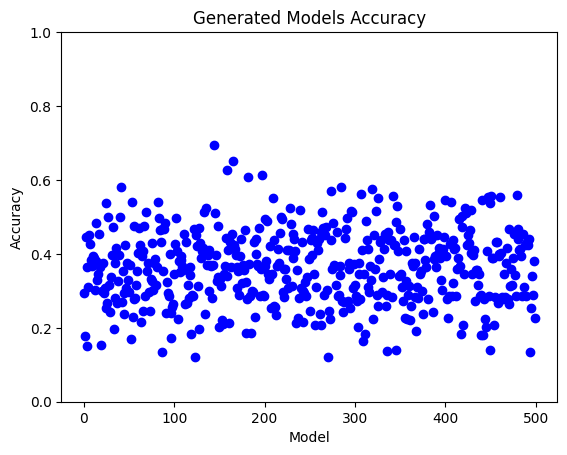

Mean accuracy: 0.3641, Std: 0.0992


In [220]:
num_of_models = 500
generated_tensors = []
with torch.no_grad():
    z = torch.randn(num_of_models, z_dim).to(device)
    vae.eval()
    w1_hats, w2_hats, w3_hats = vae.decode(z)

temp_model = SpiralModelTripleLayer().to(device)
w1_shape = temp_model.linear1.weight.shape
b1_shape = temp_model.linear1.bias.shape
w2_shape = temp_model.linear2.weight.shape
b2_shape = temp_model.linear2.bias.shape
w3_shape = temp_model.linear3.weight.shape
b3_shape = temp_model.linear3.bias.shape
w1_len = torch.prod(torch.tensor(w1_shape)).item()
w2_len = torch.prod(torch.tensor(w2_shape)).item()
w3_len = torch.prod(torch.tensor(w3_shape)).item()
generated_models = []
for i in range(num_of_models):
    w1_hat = w1_hats[i]
    w2_hat = w2_hats[i]
    w3_hat = w3_hats[i]
    w1 = w1_hat[:w1_len].view(w1_shape)
    b1 = w1_hat[w1_len:].view(b1_shape)
    w2 = w2_hat[:w2_len].view(w2_shape)
    b2 = w2_hat[w2_len:].view(b2_shape)
    w3 = w3_hat[:w3_len].view(w3_shape)
    b3 = w3_hat[w3_len:].view(b3_shape)
    new_state_dict = {
        "linear1.weight": w1,
        "linear1.bias": b1,
        "linear2.weight": w2,
        "linear2.bias": b2,
        "linear3.weight": w3,
        "linear3.bias": b3,
    }
    generated_models.append(new_state_dict)


acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)

accuracies = []
for i, state_dict in enumerate(generated_models):
    model = SpiralModelTripleLayer().to(device)
    model.load_state_dict(state_dict)
    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_acc = acc_fn(test_pred, y_test).item()
        accuracies.append(test_acc)
        print(f"{test_acc:.4f}")

        plt.scatter(i, test_acc, color="blue", marker="o")

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim([0, 1.0])
plt.title("Generated Models Accuracy")
plt.show()

mean_acc = torch.tensor(accuracies).mean().item()
std_acc = torch.tensor(accuracies).std().item()

print(f"Mean accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")